# Convolutional Neural Networks

In [1]:
import numpy as np
import pandas as pd 
import sys, os
import matplotlib.pyplot as plt

# Add the project root to sys.path (one level up from this notebook)
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))

from hypotai.data import generate_triangle_data
from hypotai.plotting import plot_triangle
from sklearn.model_selection import train_test_split

Convolution literally means applying a filter to the data to extract *different* information. This allows you to keep your shape like 2D or 3D. Imagine an image data of 256x256, for a dense (fully connected) deep neural network, you first flatten this and then you connect the inputs and outputs of every neuron with every other neuron in the next layer. <br>

Convolution allows you to keep the shape 2D, and you can place a convolution kernel e.g. like a gaussian smoothing window 5x5 matrix and glide it over the data. As a result you might be able to get a more useful information e.g. like the edges of shapes. You also do not have to connect all neurons with each other. They can be partially connected. 

There are some other concepts like Pooling (down-sampling the data), Flattening and Dense Layers. Let's go over an example.

In [2]:
df_angle = generate_triangle_data(n_samples=10_000, angle_mode="random")
X_train, X_test, y_train, y_test = train_test_split(df_angle[["a", "b", "angle_deg"]], 
                                                    df_angle["c"],test_size=0.2, random_state=42)

(np.float64(0.0), np.float64(200.0), np.float64(0.0), np.float64(100.0))

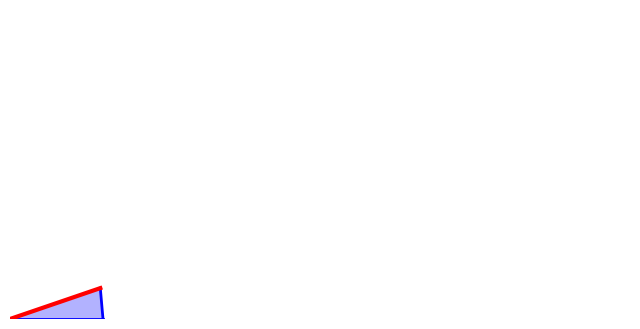

In [3]:
fig, ax = plt.subplots(figsize=(8, 8))
plot_triangle(30,10,85, annotation=False, ax=ax)
ax.set_xlim(0, 200)
ax.set_ylim(0, 100)
ax.set_aspect('equal')
ax.axis("off")

In order to use CNN, we need another package like the keras from tensorflow. The CNN works best with the image data. So let's make our lives more complicated by first creating random triangle images and labeling them with their longest side. Then we train a model.

In [4]:
from hypotai.models.convolutional import triangle_image_array, get_model

2025-06-20 16:35:50.666016: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-06-20 16:35:50.844385: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-06-20 16:35:51.014735: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750430151.165373   66152 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750430151.206438   66152 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1750430151.515231   66152 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linkin

In [5]:
X = []
y = []
np.random.seed(42)

if os.path.exists("../hypotai/data/triangle_data.npz"):
    data = np.load("../hypotai/data/triangle_data.npz")
    X = data["X"]
    y = data["y"]
else:
    # generate triangle images and labels (can take a while)
    df = generate_triangle_data(n_samples=5000, angle_mode="random")
    for i in range(5000):
        a, b, angle = df.iloc[i][["a", "b", "angle_deg"]]
        img = triangle_image_array(a, b, angle)
        # label
        c = df.iloc[i]["c"]
        
        X.append(img)
        y.append(c)

    X = np.array(X)[..., np.newaxis]  # Shape (5000, 64, 64, 1)
    y = np.array(y)

    np.savez_compressed("../hypotai/data/triangle_data.npz", X=X, y=y)

Now I defined a CNN model inside the models.convolutional to avoid crowding in here. Let's load the first model and look at it.

In [9]:
import tensorflow as tf
from tensorflow.keras import layers, models

test_model1 = get_model(model_number=1)
test_model1.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 62, 62, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 29, 29, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 12, 12, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │       294,976 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 387,713 (1.48 MB)

 Trainable params: 387,713 (1.48 MB)

 Non-trainable params: 0 (0.00 B)

Consider the first layer `Conv2d` this has 32 kernels (filters) each with 3*3 matrices as weights. In this layer, each of these 32 kernels slide through your image (by placing this 3*3 matrix on the corner and calculating new values) then also for each there is a bias value. The default padding is placing the left corner of the filter on the left corner of the image. Then you multiply all these 9 numbers and sum the results, add a bias term and apply activation. The final number is what you put in the central cell. 

You then slide one pixel and do the same thing. At the end you end up with a `(None, 62, 62, 32)` shape because 1 pixel at the top,bottom,left, and right are lost, and you have this 62x62 for each of the 32 kernels. To reduce the dimension, you apply a max pooling. Which takes these now 62x62 images and places a 2x2 kernel and only takes the maximum value in each. Effectively smoothing and reducing the size to half.

The next layer is again a convolutional 2D layer, again a 3x3 filter but this time there 64 of them. You lose the pixels at the edges again, so the image now beomces 29x29 but you have more kernels. 

makes sense? <br>

What about those number of parameters? Let's look at the first layer again. You have 3x3 kernels (weights) and 1 bias term. The image is in gray-scale so it is one dimensional `3x3x1 + 1 = 10` parameters per kernel. Since you have 32, there are 320 numbers that needs to be adjusted = total of 320 weigths and biases terms to be tuned at this layer only. <br>
Max pooling just takes the max out of 4 values, nothing to tune. 

We also need to talk about why alway Conv2D + MaxPool and why gradually increasing the number of kernels at each layers in most practices. To some extent, these all should make sense. But I do not want to make this text heavy. We can come back to this later. Let's train some.

In [12]:
# Compile the model
## We are telling model how to optimize the weights during training.
test_model1.compile(
    optimizer='adam',
    loss='mean_squared_error',
    metrics=['mae']  # Mean Absolute Error
)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

## While fitting the model, we need to fix epoch and batch number. 
### Epoch is easier, and we can use an early stopping callback to stop training 
### if the validation loss does not improve for a certain number of epochs.
history = test_model1.fit(X, y, epochs=5, batch_size=32, validation_split=0.2, callbacks=[early_stop])

Epoch 1/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 5s 38ms/step - loss: 299.9730 - mae: 12.2009 - val_loss: 262.9518 - val_mae: 11.5918
Epoch 2/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - loss: 287.9099 - mae: 11.8506 - val_loss: 267.1430 - val_mae: 12.0355
Epoch 3/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - loss: 276.3177 - mae: 11.9022 - val_loss: 225.0276 - val_mae: 10.4953
Epoch 4/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - loss: 243.5383 - mae: 11.0488 - val_loss: 236.9560 - val_mae: 11.3959
Epoch 5/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - loss: 264.4809 - mae: 11.6083 - val_loss: 264.7576 - val_mae: 12.5451


During one epoch, this is what happens: We take the first batch of 32 images, we pass them forward and get a prediction then compare them with the true values. Based on the loss, we backpropagate and update the weights and biases. Then the next 32 images goes through and does the same thing after (we have 5k images) 5000/32~=157 steps the weights and biases are updated 157 times and that makes 1 epoch. 

We then repeat this again and again until the number of epochs are covered or the loss/gain does not improve after a while.

In [17]:
# Let's fit longer and see
history = test_model1.fit(X, y, epochs=100, batch_size=64, validation_split=0.2, callbacks=[early_stop])

Epoch 1/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 65ms/step - loss: 255.2752 - mae: 11.0473 - val_loss: 220.2168 - val_mae: 10.1817
Epoch 2/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 62ms/step - loss: 250.0088 - mae: 11.0010 - val_loss: 215.7852 - val_mae: 10.4286
Epoch 3/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - loss: 246.6399 - mae: 11.0830 - val_loss: 206.4566 - val_mae: 10.1368
Epoch 4/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 67ms/step - loss: 236.8932 - mae: 10.8067 - val_loss: 199.4751 - val_mae: 9.7581
Epoch 5/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 63ms/step - loss: 230.1690 - mae: 10.5773 - val_loss: 194.8411 - val_mae: 9.4207
Epoch 6/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 60ms/step - loss: 204.9632 - mae: 9.7598 - val_loss: 188.3609 - val_mae: 9.4623
Epoch 7/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 60ms/step - loss: 213.4074 - mae: 10.0691 - val_loss: 185.0711 - val_mae: 9.4190
Epoch 8/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 61ms/step - loss: 206.9357 - mae: 9.7680 - val_loss: 191.3332 - val_mae: 9.4095
Epoch 9/100
63/

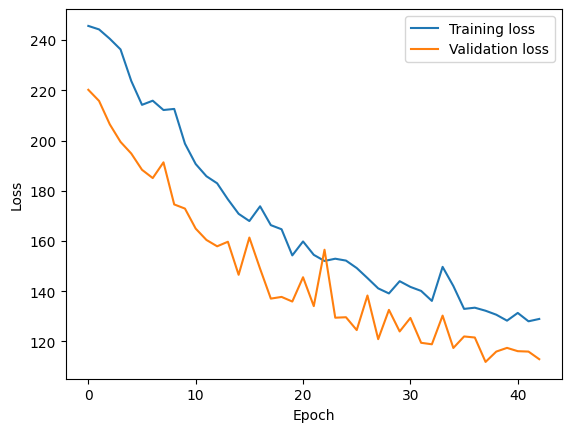

In [18]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()